In [3]:
!pip install --quiet langgraph langchain typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.9 MB/s eta 0:00:00


# **Sequential Workflows**

In [4]:
# Imports
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
from IPython.display import Image
from langchain_core.messages import SystemMessage, HumanMessage



def draw_graph(workflow_name):
  return Image(workflow_name.get_graph().draw_mermaid_png())

In [ ]:
# define state
class BMIState(TypedDict):
  weight_kg:float
  height_m: float
  bmi: float
  category: str

In [ ]:
from sre_constants import CATEGORY
# writing nodes/functions
def calculate_bmi(state: BMIState) -> BMIState:
  weight = state['weight_kg']
  height = state['height_m']

  bmi = weight/(height**2)

  state['bmi'] = round(bmi,2)

  return state

def label_bmi(state: BMIState) -> BMIState:
  bmi = state['bmi']
  if(bmi < 18.5):
    state['category'] = "Under-weight"
  elif 18.5 <= bmi < 25:
    state['category'] = "Normal"
  elif 25 <= bmi < 30:
    state['category'] = "Over-weight"
  else:
    state['category'] = "Obese"
  return state

/tmp/ipython-input-3546396336.py:1: DeprecationWarning: module 'sre_constants' is deprecated
  from sre_constants import CATEGORY


In [ ]:
# defining graph
graph = StateGraph(BMIState)

# adding nodes to the graph
graph.add_node('calculate_bmi',calculate_bmi)
graph.add_node('label_bmi',label_bmi)


# defining edges
graph.add_edge(START,'calculate_bmi')
graph.add_edge('calculate_bmi','label_bmi')
graph.add_edge('label_bmi',END)

# compilation of graph
seq_workflow = graph.compile()

In [ ]:
# executing the graph
initial_state = {'weight_kg':80,'height_m':1.9}
final_state = seq_workflow.invoke(initial_state)
print(final_state)

{'weight_kg': 80, 'height_m': 1.9, 'bmi': 22.16, 'category': 'Normal'}


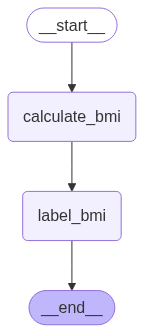

In [ ]:
# drawing graph
draw_graph(seq_workflow)

**Basic LLM based Workflow**

In [3]:
!pip install -U -q "google-generativeai>=0.7.2" # install the python SDK

In [4]:
import google.generativeai as genai

In [5]:
# credencials
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel('gemini-2.5-flash')

In [ ]:
# Definig state dictionary
class LLMState(TypedDict):
  question:str
  answer:str

In [ ]:
def llm_qa(state: LLMState) -> LLMState:
  question = state['question']

  prompt = f"Answer the following question {question}"

  answer = model.generate_content(prompt).text

  state['answer'] = answer

  return state

In [ ]:
# Graph creation
graph = StateGraph(LLMState)

graph.add_node('llm_qa',llm_qa)

graph.add_edge(START,'llm_qa')
graph.add_edge('llm_qa',END)

seq_llm_workflow = graph.compile()


In [ ]:
llm_initial_state = {'question':"what is the weight of earth"}
llm_final_state = seq_llm_workflow.invoke(llm_initial_state)
print(llm_final_state['answer'])

The concept of "weight" for Earth itself is a bit tricky, because weight is the force of gravity acting on an object's mass. Earth *is* the primary source of the gravity that gives other objects their weight.

What scientists measure and commonly refer to when discussing how "heavy" Earth is, is its **mass**.

The approximate **mass of Earth** is:

*   **5.972 × 10^24 kilograms**
*   (That's 5,972,000,000,000,000,000,000,000 kg)

If you were to imagine Earth in the gravitational field of another massive object (like the Sun), it would indeed have a "weight" relative to that object, but that's not a standard, intrinsic property of Earth itself.


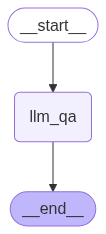

In [ ]:
draw_graph(seq_llm_workflow)

# **Parallel Workflows**

In [ ]:
class BatsmanState(TypedDict):
  runs:int
  balls:int
  fours:int
  sixes:int

  sr:float
  bpb:float
  boundary_percent:float
  summary:str

In [ ]:
def calculate_sr(state: TypedDict):
  sr = (state['runs']/state['balls'])*100
  return {'sr':sr} # updating the state partially instead entire state unlike sequentail workflow

def calculate_bpb(state:TypedDict):
  bpb = state['balls']/(state['sixes']+state['fours'])
  return {'bpb':bpb}

def calculate_boundary_percent(state: TypedDict):
  boundary_percent = (((state['sixes']*6)+(state['fours']*4))/state['runs'])*100
  return {'boundary_percent':boundary_percent}

def summary(state: TypedDict):
  summary = f"""
  strick_rate: {state['sr']}
  balls_per_bounday: {state['bpb']}
  boundary_percent: {state['boundary_percent']}
  """
  return {'summary':summary}

In [ ]:
graph = StateGraph(BatsmanState)

graph.add_node('calculate_sr',calculate_sr)
graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calculate_boundary_percent',calculate_boundary_percent)
graph.add_node('summary',summary)

graph.add_edge(START,'calculate_sr')
graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calculate_boundary_percent')
graph.add_edge('calculate_sr','summary')
graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_boundary_percent','summary')
graph.add_edge('summary',END)

parallel_workflow = graph.compile()

In [ ]:
para_initial_state = {'runs':100,'balls':50,'sixes':6,'fours':4}
parallel_workflow.invoke(para_initial_state)

{'runs': 100,
 'balls': 50,
 'fours': 4,
 'sixes': 6,
 'sr': 200.0,
 'bpb': 5.0,
 'boundary_percent': 52.0,
 'summary': '\n  strick_rate: 200.0\n  balls_per_bounday: 5.0\n  boundary_percent: 52.0\n  '}

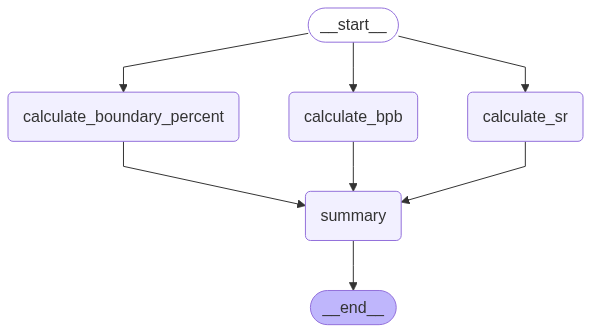

In [ ]:
draw_graph(parallel_workflow)

**Parallal workflow with Reducers**

In [ ]:
from pydantic import BaseModel, Field
from typing import Annotated
import operator
import json
import re

class EvaluationSchema(BaseModel):
  feedback: str = Field(description="Detailed feedback on the essay")
  score: float = Field(description="Score out of 10",ge=0,le=10)

In [ ]:
essay = "In the United States, 43 states, Washington D.C., Puerto Rico, and the U.S. Virgin Islands, all have their own lottery. A lottery is used for states to raise money. Licensed stores sell numbered tickets, or people can pay to choose their own numbers. When you let a machine pick your numbers, it is usually called a Quick Pick. Many people play lucky numbers, numbers associated with birthdates or other important numbers to them. The money earned from selling lottery tickets goes to pay for schools, roads, bridges, and other public services. Once a week or more, a drawing is held where the numbers are randomly picked. If your ticket has those numbers, you could win a cash prize.There are different types of lotteries, such as Powerball, Mega Millions, and Lotto. Powerball and Mega Millions are known for their large payouts. There are also instant lottery tickets that are scratch-off cards. The winnings tend to be less money, but they are extremely popular.In the United States, you can play the lottery, or buy a ticket if you are 18 years or older. If you win, usually you have the option of being paid the entire amount in one lump sum or of being paid smaller amounts over a number of years. Lottery winnings are taxable, meaning the amount you actually get is smaller than the jackpot number. People can buy lottery tickets or play the lottery at many convenience stores. Lotteries are also very popular since they advertise. There are many television commercials, radio commercials, and billboards urging people to play.Lotteries have been controversial since they are essentially a form of legalized gambling. There is concern that it can lead to people becoming addicted to gambling. There are also illegal lottery games, usually run by some forms of organized crime."
essay2 = "In the 21st century, technology has become an inseparable part of human life. From communication and education to healthcare and transportation, nearly every aspect of daily living is influenced by technological advancement. While some argue that excessive dependence on technology may erode critical thinking or human interaction, a closer examination reveals that technology, when used wisely, is a powerful tool that enhances efficiency, expands access, and enriches human experience.One of the clearest benefits of technology is its ability to connect people across vast distances. Social media, video conferencing, and instant messaging have transformed the way individuals communicate, enabling real-time collaboration regardless of geographic location. This is particularly valuable in professional and educational settings, where virtual teamwork has become the norm.Furthermore, technology has revolutionized education. Online learning platforms provide students from remote or underprivileged backgrounds with access to quality resources that were once limited to elite institutions. Interactive tools, personalized learning systems, and AI-driven feedback mechanisms contribute to more engaging and effective learning experiences.In the field of healthcare, technological innovations have significantly improved patient outcomes. Advanced diagnostic equipment, telemedicine, and data-driven treatment plans have made healthcare more precise and accessible. These developments not only save lives but also reduce the burden on healthcare systems by enabling preventive care and remote monitoring.However, it is essential to recognize and address the challenges that accompany technological progress. Issues such as digital addiction, misinformation, and data privacy require thoughtful regulation and ethical consideration. Blind acceptance of new tools without critical scrutiny can lead to unintended consequences. Thus, a balanced approach is necessary — one that embraces innovation while remaining mindful of its social and psychological implications.In conclusion, technology is neither inherently good nor bad; it is a reflection of how we choose to use it. When guided by thoughtful intention, it has the potential to elevate the human condition. Rather than resisting change, society must focus on cultivating digital literacy, ethical awareness, and adaptive thinking to ensure that technological progress serves the greater good."

In [ ]:
# Construct the prompt
prompt = f"""
You are a language evaluator. Evaluate the following essay based on its language quality.
Provide:
- A detailed feedback
- A score out of 10

Essay:
\"\"\"
{essay}
\"\"\"

Return only a JSON object with the following fields:
- feedback (string)
- score (float, between 0 and 10)

Ensure the output is valid JSON. No extra text.
"""

In [ ]:
response = model.generate_content(prompt)

In [ ]:
# Function to clean, parse, and validate Gemini output
def extract_evaluation(response) -> EvaluationSchema:
    raw_output = response.text.strip()

    def extract_json(text):
        match = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", text, re.DOTALL)
        if match:
            return match.group(1)
        return text.strip()

    clean_json_str = extract_json(raw_output)

    try:
        parsed = json.loads(clean_json_str)
        validated = EvaluationSchema(**parsed)
        return validated
    except Exception as e:
        raise ValueError(f"Failed to parse or validate response.\nError: {e}\nRaw output: {repr(clean_json_str)}")


In [ ]:
# Candidate state
class CandidateState(TypedDict):
  essay: str
  clarity_feedback: str
  language_feedback: str
  analysis_feedback: str
  overall_feedback: str
  individual_scores : Annotated[list[int],operator.add]
  average_score: float


In [ ]:
# writing functions/nodes
def evaluate_language(state:CandidateState):
  lang_prompt = f"""
You are a language evaluator. Evaluate the following essay based on its language quality.
Provide:
- A detailed feedback
- A score out of 10

Essay:
\"\"\"
{state['essay']}
\"\"\"

Return only a JSON object with the following fields:
- feedback (string)
- score (float, between 0 and 10)

Ensure the output is valid JSON. No extra text.
"""
  output = extract_evaluation(model.generate_content(lang_prompt))
  return {'language_feedback':output.feedback,'individual_scores':[round(output.score)]}

def evaluate_clarity(state:CandidateState):
  clarity_prompt = f"""
You are a language evaluator. Evaluate the following essay based on its clarity of thought.
Provide:
- A detailed feedback
- A score out of 10

Essay:
\"\"\"
{state['essay']}
\"\"\"

Return only a JSON object with the following fields:
- feedback (string)
- score (float, between 0 and 10)

Ensure the output is valid JSON. No extra text.
"""
  output = extract_evaluation(model.generate_content(clarity_prompt))
  return {'clarity_feedback':output.feedback,'individual_scores':[round(output.score)]}


def evaluate_analysis(state:CandidateState):
  analysis_prompt = f"""
You are a language evaluator. Evaluate the following essay based on depth of analysis.
Provide:
- A detailed feedback
- A score out of 10

Essay:
\"\"\"
{state['essay']}
\"\"\"

Return only a JSON object with the following fields:
- feedback (string)
- score (float, between 0 and 10)

Ensure the output is valid JSON. No extra text.
"""
  output = extract_evaluation(model.generate_content(analysis_prompt))
  return {'analysis_feedback':output.feedback,'individual_scores':[round(output.score)]}

def final_evaluate(state:CandidateState):
  summary_prompt = f"based on the following feedbacks create a summarized feedback\n language_feedback: {state['language_feedback']}\n clarity_feedback: {state['clarity_feedback']}\n analysis_feedback: {state['analysis_feedback']}\n"
  overall_feedback = model.generate_content(summary_prompt).text

  # average score
  avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

  return {
    'overall_feedback': overall_feedback,
    'average_score': round(avg_score)
}

In [ ]:
# creation of graph
graph = StateGraph(CandidateState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_clarity',evaluate_clarity)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('final_evaluate',final_evaluate)

graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_clarity')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge('evaluate_language','final_evaluate')
graph.add_edge('evaluate_clarity','final_evaluate')
graph.add_edge('evaluate_analysis','final_evaluate')
graph.add_edge('final_evaluate',END)

parallel_workflow2 = graph.compile()


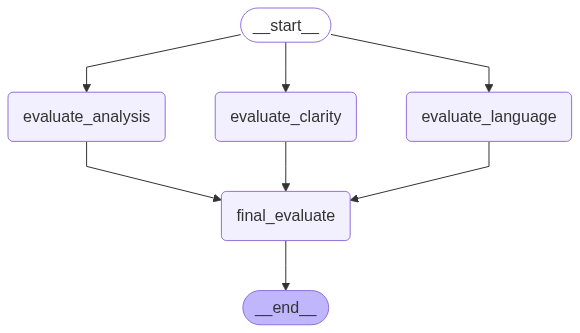

In [ ]:
parallel_workflow2

In [ ]:
initial_state = {'essay':essay2}
parallel_workflow2.invoke(initial_state)

{'essay': 'In the 21st century, technology has become an inseparable part of human life. From communication and education to healthcare and transportation, nearly every aspect of daily living is influenced by technological advancement. While some argue that excessive dependence on technology may erode critical thinking or human interaction, a closer examination reveals that technology, when used wisely, is a powerful tool that enhances efficiency, expands access, and enriches human experience.One of the clearest benefits of technology is its ability to connect people across vast distances. Social media, video conferencing, and instant messaging have transformed the way individuals communicate, enabling real-time collaboration regardless of geographic location. This is particularly valuable in professional and educational settings, where virtual teamwork has become the norm.Furthermore, technology has revolutionized education. Online learning platforms provide students from remote or un

# **Conditional Workflows**

# **Iterative Workflows**

In [6]:
response = model.generate_content("what is llm?")
response.text

'LLM stands for **Large Language Model**.\n\nIn essence, an LLM is a type of **artificial intelligence (AI)** program that has been trained on a **massive amount of text data** to understand, generate, and process human language in a highly sophisticated way.\n\nLet\'s break down each part of the name:\n\n1.  **Large:**\n    *   **Data:** LLMs are trained on enormous datasets, often comprising trillions of words from books, articles, websites, conversations, and more. This vast exposure allows them to learn complex patterns, grammar, facts, and even nuances of human communication.\n    *   **Parameters:** These models have billions, or even trillions, of "parameters." Think of parameters as the internal variables or knobs that the model adjusts during its training process to learn relationships and make predictions. More parameters generally mean a more complex and capable model.\n\n2.  **Language:**\n    *   The primary focus of LLMs is **human language (natural language)**. They are 

Design a workflow to generate a tweet and post it on X/tweeter autonomously after approval.

In [2]:
# defining states
class TweetState(BaseModel):
  topic: str
  tweet: str
  evaluation: Literal['Approved','needs_improvement']
  feedback: str
  iteration: int
  max_iteration: int

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(
        description="Whether the tweet passes evaluation."
    )
    feedback: str = Field(
        description="One paragraph explaining the strengths and weaknesses of the tweet."
    )

NameError: name 'BaseModel' is not defined

In [1]:
def generate_tweet(state: TweetState):
  # prompt
  messages = [
      SystemMessage(content="You are a funny and clever Twitter/X influencer."),
      HumanMessage(content=f"""
      write a short, original and hilarious tweet on the topic: "{state['topic']}".

      Rules:
      - Do NOT use question-answer format.
      - Max 280 characters.
      - Use observational humor, irony, sarcasm, or cultural references.
      - Think in meme logic, punchlines, or relatable takes.
      - Use simple, day to day english
      """)
  ]

  # send generator_llm
  reponse = model.generate_content(messages).text

  # return response
  return {'tweet': response}

# tweet evaluation function
def evaluate_tweet(state: TweetState):
  # prompt
  prompt = f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Don't end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in valid JSON:
```json
{{
  "evaluation": "approved" or "needs_improvement",
  "feedback": "One paragraph explaining the strengths and weaknesses"
}}

"""
  #

# tweet optimization function
def optimize_tweet():
  pass

SyntaxError: incomplete input (ipython-input-1569547773.py, line 24)

In [ ]:
graph = StateGraph(TweetState)

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('evaluate_tweet',evaluate_tweet)
graph.add_node('optimize_tweet',optimize_tweet)
